# Run these cells if you are using Google Collab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Data/pilot_hunda/pilot-457665316.jpg  
  inflating: Data/pilot_hunda/pilot-463390180.jpg  
  inflating: Data/pilot_hunda/pilot-464430159.jpg  
  inflating: Data/pilot_hunda/pilot-469352450.jpg  
  inflating: Data/pilot_hunda/pilot-470068189.jpg  
  inflating: Data/pilot_hunda/pilot-474385610.jpg  
  inflating: Data/pilot_hunda/pilot-475427792.jpg  
  inflating: Data/pilot_hunda/pilot-477103483.jpg  
  inflating: Data/pilot_hunda/pilot-477151761.jpg  
  inflating: Data/pilot_hunda/pilot-478856042.jpg  
  inflating: Data/pilot_hunda/pilot-481151177.jpg  
  inflating: Data/pilot_hunda/pilot-481405049.jpg  
  inflating: Data/pilot_hunda/pilot-481477725.jpg  
  inflating: Data/pilot_hunda/pilot-482487503.jpg  
  inflating: Data/pilot_hunda/pilot-482661109.jpg  
  inflating: Data/pilot_hunda/pilot-488108644.jpg  
  inflating: Data/pilot_hunda/pilot-490753100.jpg  
  inflating: Data/pilot_hunda/pilot-491639161.jpg  
  inflating: 

In [ ]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import cv2 as cv
import matplotlib.pyplot as plt


# The main functions

In [ ]:
def build_data(data_path):
    """Form a two numpy arrays contain data and their labels

    Keyword arguments:
    data_path -- the path of data
    """
    directories = os.listdir(data_path)
    data = []
    labels = []
    valid_images = [".jpg",".png"] 

    for label_num ,path in enumerate(directories):
        path = data_path + "/" + path
        for img_file in os.listdir(path):
            ext = os.path.splitext(img_file)[1]
            if ext.lower() not in valid_images:
                continue
            img = cv.imread(os.path.join(path,img_file))
            
            if img is not None:
                img = cv.resize(img, (224,224))
                data.append(img)
                labels.append(label_num)

    data = np.array(data)
    labels = np.array(labels)

    labels = tf.keras.utils.to_categorical(labels, dtype='float32')

    return data, labels



In [ ]:
def model_build (layers, opt, augmentation=False, regularization=False,
                 l2_value=0.01, dropout_value=0.,  input_shape=(224,224,3)):
    """Build our CNN and evaluate it on test data.

    Keyword arguments:
    layers -- list of CNN layers parameters
    opt -- the optimizer 
    augmentation -- using of augmentation True\False (Default value False)
    regularization -- using of regularization True\False (Default value False)
    l2_value -- value of l2 for regularization (Default value 0.01)
    dropout_value -- float value from 0.0 t0 1.0 (Default value 0.0)
    input_shape -- input_shape for our CNN
    """
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(input_shape))
    model.add(tf.keras.layers.Rescaling(scale=1./255))
    
    if augmentation:
         model.add(data_augmentation)

    l=0
    if regularization:
        l = l2_value

    for num_filter, size_filter, padding in layers:
        model.add(tf.keras.layers.Conv2D(filters= num_filter, kernel_size= size_filter, activation= 'relu',
                                         padding = padding, kernel_regularizer =tf.keras.regularizers.l2( l)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Conv2D(filters= num_filter, kernel_size= size_filter, activation= 'relu',
                                         padding = padding, kernel_regularizer =tf.keras.regularizers.l2(l)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=2))
        model.add(tf.keras.layers.Dropout(dropout_value))


    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(2048, activation = 'relu', 
                                    kernel_regularizer =tf.keras.regularizers.l2(l)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_value))
    model.add(tf.keras.layers.Dense(1024, activation = 'relu', 
                                    kernel_regularizer =tf.keras.regularizers.l2(l)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(dropout_value))
    model.add(tf.keras.layers.Dense(6, activation = 'softmax'))
    

    callback=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10,
                                              mode="min", restore_best_weights=True)
    
    model.compile(optimizer=opt,loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data = (X_valid,y_valid),
                        epochs=500, callbacks = [callback])
    
    model.evaluate(X_test,y_test)
    
    return model, history



In [ ]:
def sliding_window(image, step, w_size):
    """Generate windows

    Keyword arguments:
    image -- image to  path of datimplement our window on it.
        step -- int value step of our window
        w_size -- tuple, the size of our window (rows, cloumns)
    """
    for y in range(0, image.shape[0] - w_size[0], step):
        for x in range(0, image.shape[1] - w_size[1], step):
            yield (x, y, image[y:y + w_size[0], x:x + w_size[1]])

In [ ]:
def image_pyramid(image, scale, minSize):
    """Generate images in deffirent scales

    Keyword arguments:
    image -- original image.
    scale -- scale value
    w_size -- size of our window (rows, cloumns)
    """
    yield image

    while True:
        w = int(image.shape[1] / scale)
        h = int(image.shape[0] / scale)
        image = cv.resize(image,(h,w))

        if image.shape[0] < minSize[0] or image.shape[1] < minSize[1]:
            break

        yield image

In [ ]:
def non_max_suppression(boxes, proba, labels, overlap_thresh):
    """Implement IOU algorithm to detect overlap boxes then delete them

    Keyword arguments:
    boxes -- list of boxes to test their overlap.
    proba -- list of probabilities of boxes
    labels -- list of labels of boxes
    overlap_thresh -- threshold of overlap
    """
        if len(boxes) == 0:
            return [],[],[]
        
        pick = []
        # grab the coordinates of the bounding boxes
        x1 = boxes[:,0]
        y1 = boxes[:,1]
        x2 = boxes[:,2]
        y2 = boxes[:,3]
        area = (x2 - x1 + 1) * (y2 - y1 + 1)
        idxs = np.argsort(proba)
        while len(idxs) > 0:
            last = len(idxs) - 1
            i = idxs[last]
            pick.append(i)
            suppress = [last]
            for pos in range(0, last):
                j = idxs[pos]
                xx1 = max(x1[i], x1[j])
                yy1 = max(y1[i], y1[j])
                xx2 = min(x2[i], x2[j])
                yy2 = min(y2[i], y2[j])
                # compute the width and height of the instraction bounding box
                w = max(0, xx2 - xx1 + 1)
                h = max(0, yy2 - yy1 + 1)
                # compute the union bounding box
                union_area = area[i] + area[j] - float(w*h)
                # compute the IOU
                overlap = float(w*h) / union_area

                if overlap > overlap_thresh:
                    suppress.append(pos)

            idxs = np.delete(idxs, suppress)
            
        return boxes[pick], proba[pick],labels_[pick]

In [ ]:
def plotcurves(history, epochs):
    plt.figure(figsize=(10, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot([index for index in range(1, epochs+1)],
             history.history['loss'], label='Training Loss')
    plt.plot([index for index in range(1, epochs+1)], 
             history.history['val_loss'],ls='--', label='Validation Loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot([index for index in range(1, epochs+1)], 
             history.history['accuracy'], label='Training accuracy', )
    plt.plot([index for index in range(1, epochs+1)], 
             history.history['val_accuracy'],ls='--', label='Validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()



In [ ]:
def predict_random_test_images():
    indices = np.random.randint(0, X_test.shape[0], 9)
    plt.figure(figsize=(20, 15))
    for i in range(len(indices)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_test[i].astype("uint8"))
        plt.axis('off')
        our_cnn_pred = class_names[np.argmax(final_model.predict(np.expand_dims(X_test[i], 0)))]
        plt.title(f'Our CNN: {our_cnn_pred}, actual class name: {class_names[np.argmax(y_test[i])]}')

In [ ]:
def plt_imshow(title, image):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    x=plt.figure(figsize = (10,10))
    fig = x.add_subplot(1,1,1)
    fig.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

# Preparing Data using our function **build_data**.

In [ ]:
data_path =r'/content/Data'
data, labels = build_data(data_path)

#Display information about our data.

In [ ]:
print('our images data shape is ', data.shape)
print('our labels shape is ', labels.shape)

our images data shape is  (6869, 224, 224, 3)
our labels shape is  (6869, 6)


In [ ]:
class_names = os.listdir(data_path)

Show some data **images**

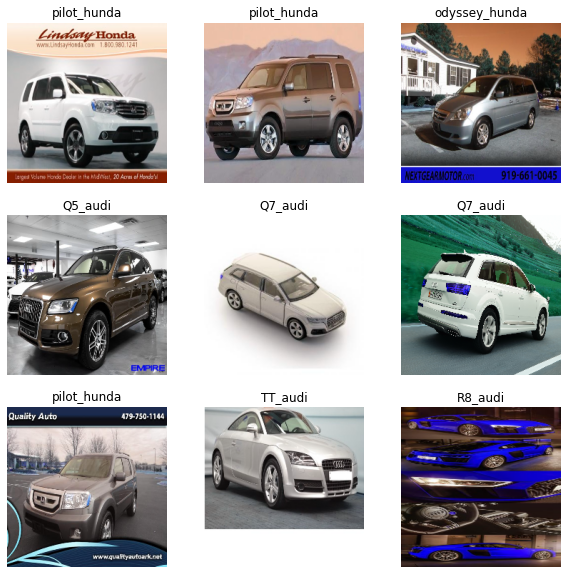

In [ ]:
plt.figure(figsize=(10, 10))
indices = np.random.randint(0, len(data), 9)

j=0
for i in indices:
    ax = plt.subplot(3, 3, j + 1)
    j +=1
    plt.imshow(data[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

Show data distribution

In [ ]:
unique, counts = np.unique( [np.argmax(i) for i in labels] , return_counts=True)
fig, axes = plt.subplots(figsize=(9,5), dpi=100)
unique_n = [class_names[i] for i in unique]
plt.bar(unique_n, height=counts)
plt.title('disribution of the whole data');

split data for training and testing process

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2,
                                                random_state=42)

In [ ]:
print('our training data shape is ', X_train.shape)
print('our validation data shape is ', X_valid.shape)
print('our testing shape is ', X_test.shape)

our training data shape is  (4396, 224, 224, 3)
our validation data shape is  (1099, 224, 224, 3)
our testing shape is  (1374, 224, 224, 3)


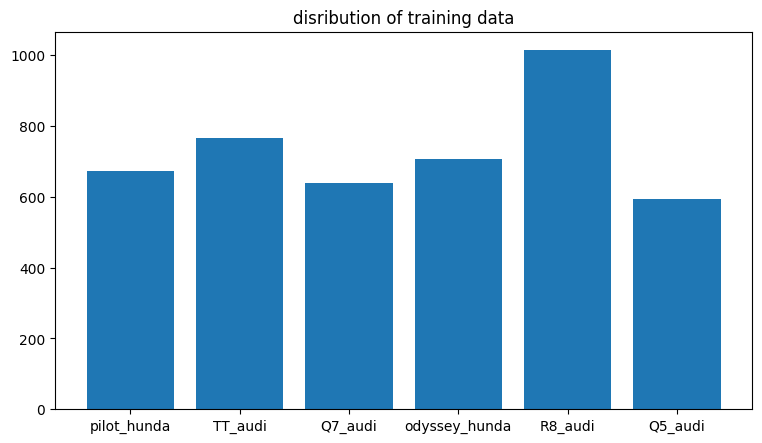

In [ ]:
unique, counts = np.unique( [np.argmax(i) for i in y_train] , return_counts=True)

fig, axes = plt.subplots(figsize=(9,5), dpi=100)
unique_n = [class_names[i] for i in unique]
plt.bar(unique_n, height=counts)
plt.title('disribution of training data');

#build our augmentation model

Build **augmentation** model

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
    tf.keras.layers.RandomZoom(.2, .2),
    tf.keras.layers.RandomZoom(-.3, -.3),
    tf.keras.layers.RandomContrast(factor=.2, seed=1),
], name='Augmentation_model')

# build and training our model using build_model function

In [ ]:
layers = [(32,3, 'valid'),(64,5, 'valid'), (128,5, 'valid'),(128,7, 'valid')]

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

final_model, history_fmodel = model_build(layers= layers, opt = adam, augmentation= True, 
                                          regularization = True, dropout_value= 0.6)

Epoch 1/500
138/138 [==============================] - 36s 209ms/step - loss: 42.6586 - accuracy: 0.1920 - val_loss: 41.0379 - val_accuracy: 0.1592
Epoch 2/500
138/138 [==============================] - 25s 180ms/step - loss: 41.3005 - accuracy: 0.1952 - val_loss: 40.0011 - val_accuracy: 0.1592
Epoch 3/500
138/138 [==============================] - 25s 180ms/step - loss: 39.9045 - accuracy: 0.1979 - val_loss: 38.8213 - val_accuracy: 0.1365
Epoch 4/500
138/138 [==============================] - 25s 182ms/step - loss: 38.6240 - accuracy: 0.2047 - val_loss: 37.5841 - val_accuracy: 0.1592
Epoch 5/500
138/138 [==============================] - 25s 182ms/step - loss: 37.2995 - accuracy: 0.2043 - val_loss: 36.6158 - val_accuracy: 0.1401
Epoch 6/500
138/138 [==============================] - 25s 183ms/step - loss: 35.9207 - accuracy: 0.2186 - val_loss: 35.2120 - val_accuracy: 0.1556
Epoch 7/500
138/138 [==============================] - 25s 183ms/step - loss: 34.6364 - accuracy: 0.2313 - val_l

In [ ]:
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 Augmentation_model (Sequent  (None, 224, 224, 3)      0         
 ial)                                                            
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 220, 220, 32)    

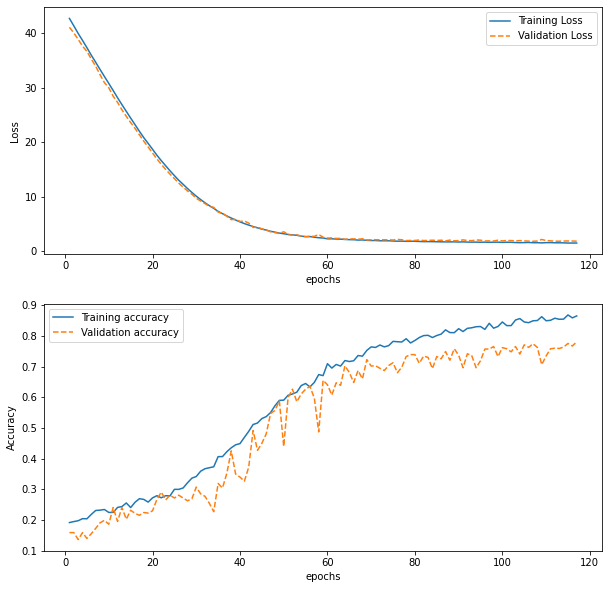

In [ ]:
plotcurves(history_fmodel,117)

# Show results of our model

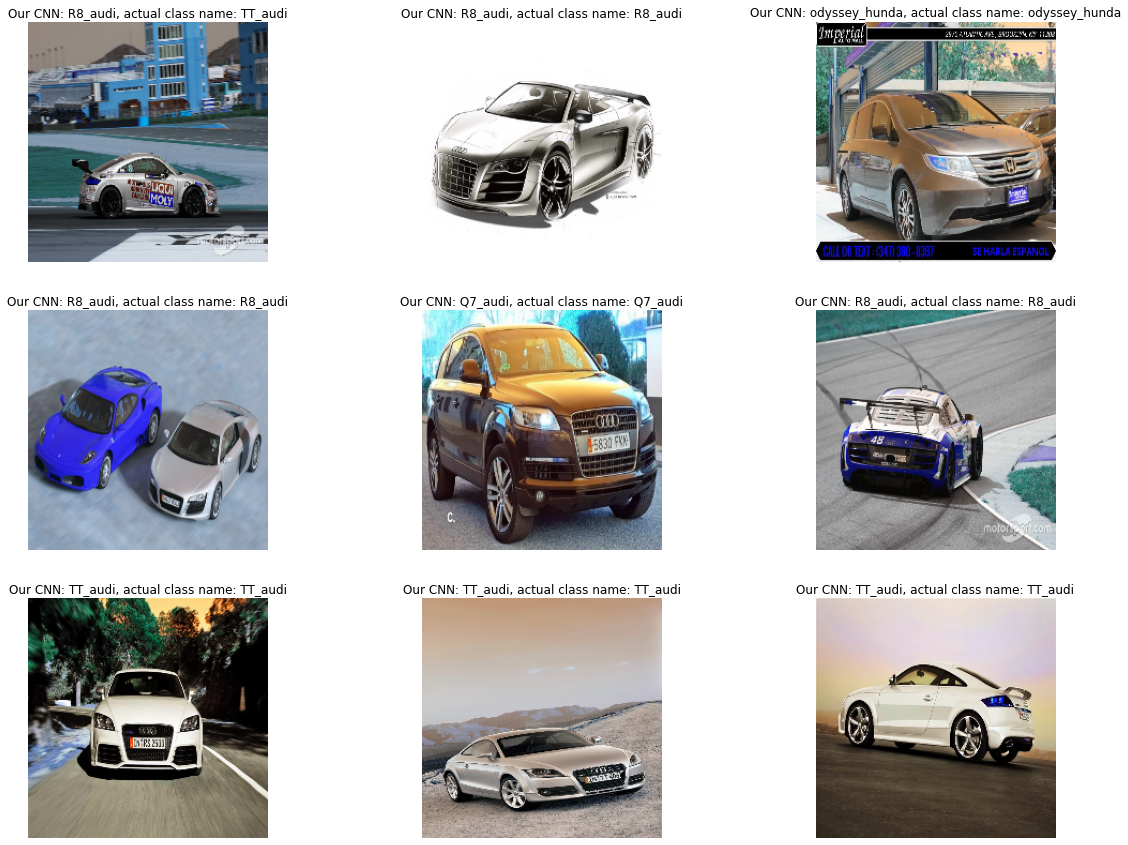

In [ ]:
predict_random_test_images()

In [ ]:
y_pred = final_model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
import pandas as pd
cm_df = pd.DataFrame(cm,
                     index = [class_names], 
                     columns = class_names)

Text(0.5, 32.09375, 'Predicted Values')

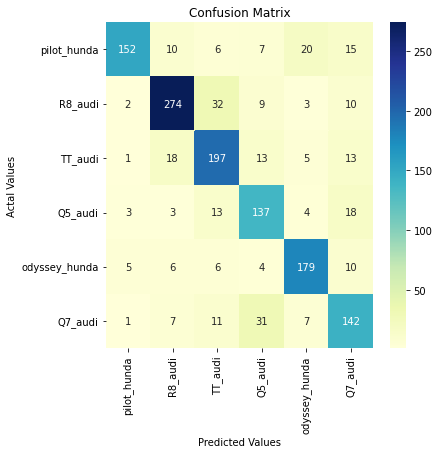

In [ ]:
import seaborn as sns
plt.figure(figsize=(6,6))
heat_map = sns.heatmap(cm_df, annot=True, fmt='d',cmap="YlGnBu" )
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

# use RMSprop as our optimizer

In [ ]:
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)


In [ ]:
model_RMSprop, history_RMSprop = model_build(layers= layers, opt= rmsprop, augmentation= True, 
                                             regularization = True, dropout_value= 0.6)

Epoch 1/500
138/138 [==============================] - 29s 184ms/step - loss: 42.6005 - accuracy: 0.1915 - val_loss: 40.9877 - val_accuracy: 0.1592
Epoch 2/500
138/138 [==============================] - 25s 182ms/step - loss: 41.0530 - accuracy: 0.1954 - val_loss: 40.0283 - val_accuracy: 0.1592
Epoch 3/500
138/138 [==============================] - 25s 182ms/step - loss: 39.5391 - accuracy: 0.2079 - val_loss: 38.4762 - val_accuracy: 0.1592
Epoch 4/500
138/138 [==============================] - 25s 183ms/step - loss: 38.0528 - accuracy: 0.2106 - val_loss: 36.7194 - val_accuracy: 0.1547
Epoch 5/500
138/138 [==============================] - 25s 184ms/step - loss: 36.3913 - accuracy: 0.2143 - val_loss: 34.8697 - val_accuracy: 0.1993
Epoch 6/500
138/138 [==============================] - 25s 185ms/step - loss: 34.6997 - accuracy: 0.2095 - val_loss: 33.2261 - val_accuracy: 0.2084
Epoch 7/500
138/138 [==============================] - 26s 186ms/step - loss: 33.0003 - accuracy: 0.2100 - val_l

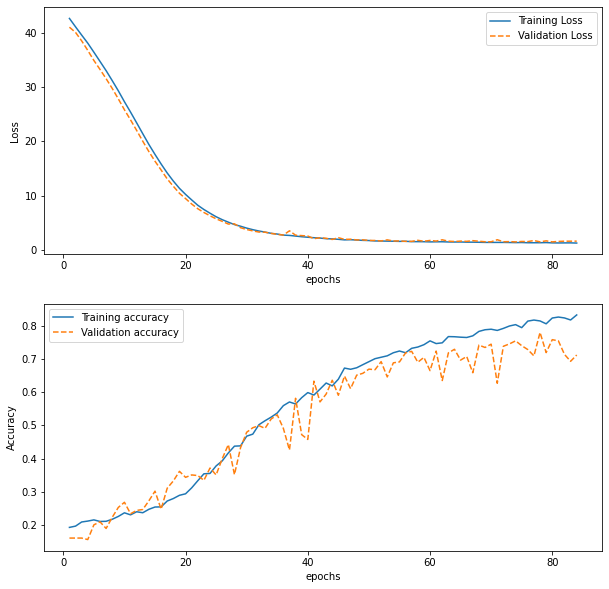

In [ ]:
plotcurves(history_RMSprop,84)

In [ ]:
y_pred = model_RMSprop.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
import pandas as pd
cm_df = pd.DataFrame(cm,
                     index = [class_names], 
                     columns = class_names)

Text(0.5, 32.09375, 'Predicted Values')

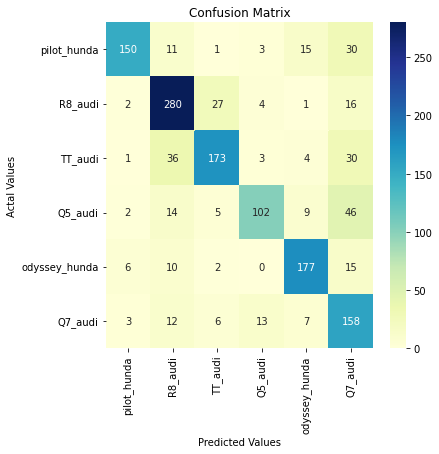

In [ ]:
import seaborn as sns
plt.figure(figsize=(6,6))
heat_map = sns.heatmap(cm_df, annot=True, fmt='d',cmap="YlGnBu" )
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')

# VGG16

In [ ]:
VGG16 = tf.keras.applications.VGG16(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

VGG16.trainable = False

preprocess_input = tf.keras.applications.vgg16.preprocess_input
flatten_layer = tf.keras.layers.Flatten(name='Global_Average_Pooling_Layer')
prediction_layer = tf.keras.layers.Dense(6, activation='softmax', name='Output_layer')

inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = VGG16(x, training=False)
x = flatten_layer(x)
outputs = prediction_layer(x)

TF_Model = tf.keras.Model(inputs, outputs)  

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
callback=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, 
                                          mode="min", restore_best_weights=True)

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
TF_Model.compile(optimizer=adam,loss='categorical_crossentropy',
                 metrics=['accuracy'])
history = TF_Model.fit(X_train, y_train, validation_data = (X_valid,y_valid), 
                       epochs=500, callbacks = [callback])

TF_Model.evaluate(X_test,y_test)

Epoch 1/500
138/138 [==============================] - 42s 201ms/step - loss: 10.2284 - accuracy: 0.3854 - val_loss: 6.8241 - val_accuracy: 0.4959
Epoch 2/500
138/138 [==============================] - 25s 183ms/step - loss: 3.1252 - accuracy: 0.6952 - val_loss: 5.5603 - val_accuracy: 0.5769
Epoch 3/500
138/138 [==============================] - 26s 185ms/step - loss: 1.0761 - accuracy: 0.8490 - val_loss: 5.3004 - val_accuracy: 0.5878
Epoch 4/500
138/138 [==============================] - 26s 188ms/step - loss: 0.3695 - accuracy: 0.9302 - val_loss: 4.9882 - val_accuracy: 0.6096
Epoch 5/500
138/138 [==============================] - 26s 189ms/step - loss: 0.1409 - accuracy: 0.9679 - val_loss: 4.8846 - val_accuracy: 0.6151
Epoch 6/500
138/138 [==============================] - 26s 190ms/step - loss: 0.0754 - accuracy: 0.9825 - val_loss: 4.7060 - val_accuracy: 0.6151
Epoch 7/500
138/138 [==============================] - 27s 193ms/step - loss: 0.0471 - accuracy: 0.9929 - val_loss: 4.7739 

[4.762383460998535, 0.6499271988868713]

# Resnet50

In [ ]:
resnet = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is 
# ideal for feature extraction.


resnet.trainable = False
preprocess_input = tf.keras.applications.resnet50.preprocess_input
prediction_layer = tf.keras.layers.Dense(6, activation='softmax', name='Output_layer')


inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = resnet(x, training=False)
x = flatten_layer(x)
outputs = prediction_layer(x)
TF_Model = tf.keras.Model(inputs, outputs)  

In [ ]:
callback=tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10, 
                                          mode="min", restore_best_weights=True)

adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
TF_Model.compile(optimizer=adam,loss='categorical_crossentropy',
                 metrics=['accuracy'])
history = TF_Model.fit(X_train, y_train, validation_data = (X_valid,y_valid), 
                       epochs=500, callbacks = [callback])

TF_Model.evaluate(X_test,y_test)

Epoch 1/500
138/138 [==============================] - 21s 128ms/step - loss: 1.7508 - accuracy: 0.5409 - val_loss: 1.3409 - val_accuracy: 0.6670
Epoch 2/500
138/138 [==============================] - 16s 113ms/step - loss: 0.2229 - accuracy: 0.9245 - val_loss: 1.1521 - val_accuracy: 0.6943
Epoch 3/500
138/138 [==============================] - 16s 114ms/step - loss: 0.0600 - accuracy: 0.9900 - val_loss: 1.1444 - val_accuracy: 0.7170
Epoch 4/500
138/138 [==============================] - 16s 114ms/step - loss: 0.0358 - accuracy: 0.9966 - val_loss: 1.1026 - val_accuracy: 0.7270
Epoch 5/500
138/138 [==============================] - 18s 130ms/step - loss: 0.0366 - accuracy: 0.9970 - val_loss: 1.0776 - val_accuracy: 0.7370
Epoch 6/500
138/138 [==============================] - 16s 115ms/step - loss: 0.0332 - accuracy: 0.9973 - val_loss: 1.1374 - val_accuracy: 0.7389
Epoch 7/500
138/138 [==============================] - 16s 115ms/step - loss: 0.0381 - accuracy: 0.9973 - val_loss: 1.0951 -

[0.9148987531661987, 0.7598253488540649]

# Car detection process

In [ ]:
WIDTH = 600
PYR_SCALE = 1.5
WIN_STEP = 20
Region_SIZE = (150,200)
INPUT_SIZE = (224, 224)

In [ ]:
#orig = cv.imread(r'/content/drive/MyDrive/aa84475df2eee000737d4b013917a523x.jpg')
orig = X_test[5]
orig = cv.resize(orig, (WIDTH,WIDTH))
(H, W) = orig.shape[:2]

In [ ]:
pyramid = image_pyramid(orig, scale=PYR_SCALE, minSize=Region_size)

regions = []
locs = []


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

for image in pyramid:
    scale = W / float(image.shape[1])

    for (x, y, region) in sliding_window(image, WIN_STEP, Region_size):

        x = int(x * scale)
        y = int(y * scale)
        w = int(Region_size[1] * scale)
        h = int(Region_size[0] * scale)

        region = cv.resize(region, INPUT_SIZE)
        region = img_to_array(region)

        regions.append(region)
        locs.append((x, y, x + w, y + h))

In [ ]:
regions = np.array(regions, dtype="float32")
preds_ = final_model.predict(regions)
preds = []
for i in preds_:
    label = np.argmax(i)
    prob = np.max(i)
    preds.append((label,prob))
labels = {}

In [ ]:
for (i, p) in enumerate(preds):
    (label, prob) = p
    if prob >= 0.95:
        box = locs[i]

        L = []
        L.append((box, prob))
        labels[label] = L

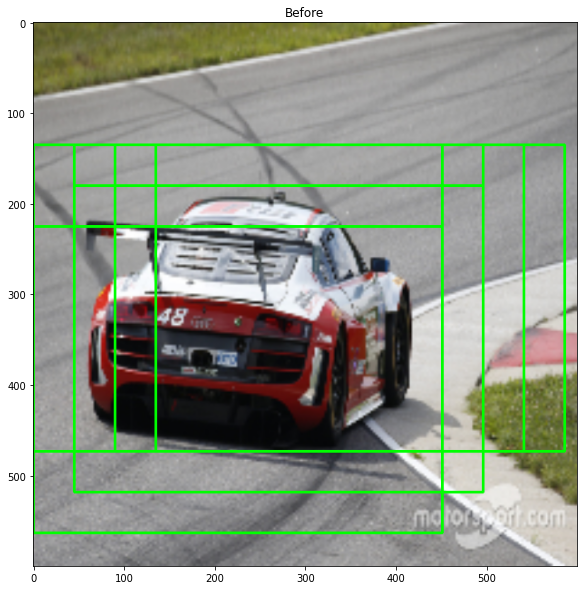

indxs are  [ 1  0 10  3  2  9  4  5  8  7  6]
[6]


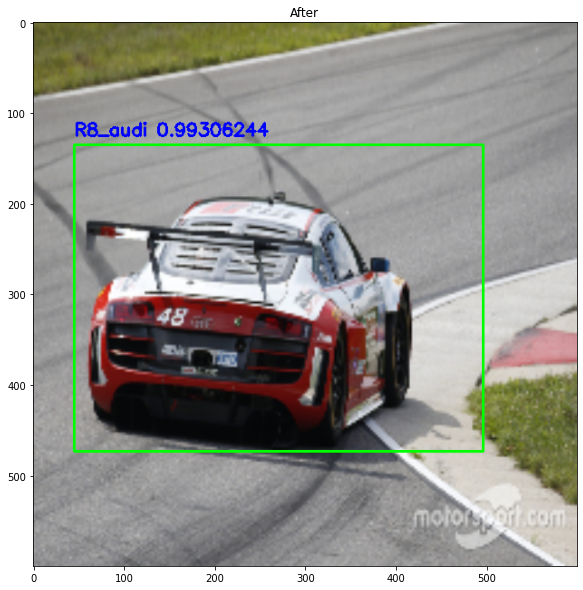

'for (startX, startY, endX, endY) in boxes:\n\t\t# draw the bounding box and label on the image\n\t\tcv.rectangle(clone, (startX, startY), (endX, endY),\n\t\t\t(0, 255, 0), 2)\n\t\ty = startY - 10 if startY - 10 > 10 else startY + 10\n\t\tcv.putText(clone, class_names[label], (startX, y),cv.FONT_HERSHEY_SIMPLEX, 0.65, (255, 0 , 0), 2)\n\n\t# show the output after apply non-maxima suppression\n\tplt_imshow("After", clone)'

In [ ]:
allboxes=[]
allproba=[]
allabels = []

clone = orig.copy()
# loop over the labels for each of detected objects in the image
for label in labels.keys():
    boxes = np.array([p[0] for p in labels[label]])
    allboxes.append(boxes)
    proba = np.array([p[1] for p in labels[label]])
    allproba.append(proba)
    itr = int(proba.shape[0])
    allabels.append([label]*itr)

    for p in labels[label]:
    # draw the bounding box on the image
        (startX, startY, endX, endY) = p[0]

        cv.rectangle(clone, (startX, startY), (endX, endY),
                    (0, 255, 0), 2)

plt_imshow("Before", clone)
clone = orig.copy()

boxes=[]
porbas=[]
labels_ = []

for i in allboxes:
    for j in i:
        boxes.append(j)

for i in allproba:
    for j in i:
        porbas.append(j)

for i in allabels:
    for j in i:
        labels_.append(j)

boxes=np.array(boxes)
porbas=np.array(porbas)
labels_=np.array(labels_)

boxes,porbas,labels_=non_max_suppression(boxes,porbas,labels_,0.05)

# loop over all bounding boxes that were kept after applying
# non-maxima suppression
for i,box in enumerate(boxes):
    (startX, startY, endX, endY) = box
    cv.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv.putText(clone, class_names[labels_[i]]+" "+str(porbas[i]), (startX, y),
               cv.FONT_HERSHEY_SIMPLEX, 0.65, (255, 0 , 0), 2)
    
plt_imshow("After", clone)